# **Part 4: Custom Model - Further Work**
The goal was to create a new model.

In [ ]:
import numpy as np
import os
import json
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision.transforms as T

from annotations import load_annotations, visualize_annotations
from custom_dataset import visualize_semantic_dataloader

In [2]:
# Checking CUDA availability and setting the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device = }")

device = 'cpu'


### **Dataset Preparation**

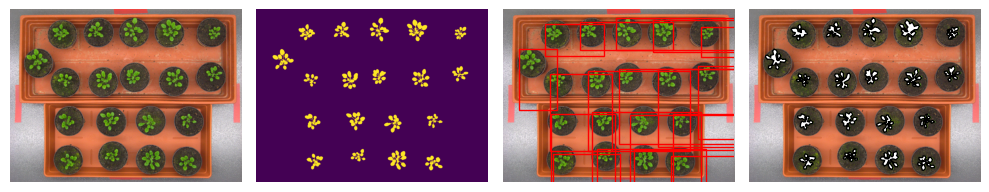

In [3]:
train_dir = './Data/pot_plants_database/train'
annotations_file = os.path.join(train_dir, 'annotations.json')
annotations = load_annotations(annotations_file)

# visualizing the first image along with its annotations
image_id = 4   
image_name = os.path.join(train_dir, annotations['images'][image_id]['file_name'])
label_name = os.path.join(train_dir, annotations['images'][image_id]['label_file'])
visualize_annotations(image_name, label_name, image_id, annotations)

### **Initializing Dataloaders**

In [4]:
class NewSegmentationDataset():
    def __init__(self, data_folder, annotation_file, transforms=None):
        self.data_folder = data_folder
        self.transform = transform
        self.resize = 256
        self.height = self.resize
        self.width = self.resize
        
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
            
        self.images = [os.path.join(data_folder, image['file_name']) for image in self.annotations['images']]
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")

        mask_path = self.images[idx].replace("_rgb", "_fg")
        mask = Image.open(mask_path)
        mask = np.array(mask, dtype=np.uint8)
        
        # Apply transformations if any
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ])
        
        if self.transform is not None:
            image = self.transform(image)
            mask = transform(mask)
        else:
            # Default transformation to Tensor
            image = T.ToTensor()(image)
            mask = T.ToTensor()(mask)
        
        return image, mask


In [5]:
data_folder_train = './Data/pot_plants_database/train'
annotations_train = os.path.join(data_folder_train, 'annotations.json')

data_folder_test = './Data/pot_plants_database/test'
annotations_test = os.path.join(data_folder_test, 'annotations.json')

# defining transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating training and testing datasets
pplant_train_dataset = NewSegmentationDataset(data_folder=data_folder_train, annotation_file=annotations_train, transforms=transform)
pplant_test_dataset = NewSegmentationDataset(data_folder=data_folder_test, annotation_file=annotations_test, transforms=transform)

# Creating training and testing dataloaders
BATCH_SIZE = 4
pplant_train_loader = DataLoader(pplant_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
pplant_test_loader = DataLoader(pplant_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


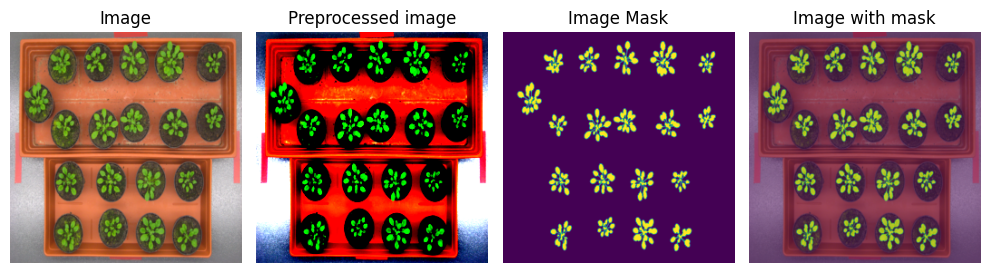

In [6]:
visualize_semantic_dataloader(pplant_train_loader)

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=2)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x

class MaskDecoder(nn.Module):
    def __init__(self, hidden_dim, output_channels=1):
        super(MaskDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        return self.decoder(x)
     
     
class MaskPredictionModel(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, hidden_channels=64):
        super(MaskPredictionModel, self).__init__()
        self.hidden_channels = hidden_channels
        
        self.encoder1 = ConvBlock(in_channels, 64)
        self.encoder2 = ConvBlock(64, 128)
        self.encoder3 = ConvBlock(128, 256)
        self.encoder4 = ConvBlock(256, 512)
        self.encoder5 = ConvBlock(512, 512)
        
        self.lstm = nn.LSTM(input_size=(8*8*512), 
                            hidden_size=1024,
                            num_layers=2,
                            batch_first=True)
        
        self.decoder = MaskDecoder(hidden_channels)
        
    def forward(self, image, mask):
        # Concatenate image and mask features
        x = torch.cat([image, mask], dim=1)

        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)
        x = self.encoder5(x)
        
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, 1, -1)
        
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = lstm_out.view(batch_size, self.hidden_channels, 4, 4)
        
        x = self.decoder(lstm_out)
        return x
